In [47]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

def imshow(img, ax=None, title="", bgr=True):
    # since plt and cv2 have different RGB sorting
    if bgr:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if ax == None:
        plt.imshow(img.astype(np.uint8))
        plt.axis("off")
        plt.title(title)
    else:
        ax.imshow(img.astype(np.uint8))
        ax.set_axis_off()
        ax.set_title(title)
        
plt.rcParams["figure.figsize"] = (12,6)

## Affine Transformations
$$\begin{bmatrix}x'\\y'\end{bmatrix} = 
\begin{bmatrix}a&b&e\\c&d&f\end{bmatrix} \begin{bmatrix}x\\y\\1\end{bmatrix} $$
is the combination of a linear transformation $\begin{bmatrix}a&b\\c&d\end{bmatrix}$ plus a translation $\begin{bmatrix}e\\f\end{bmatrix} $

#### Properties
- Origin $\Rightarrow (e, f)$
- Lines map to lines 
- Parallel lines remain parallel
- Preserves ratios
- Closed under composition
- Rectangles go to parallelograms

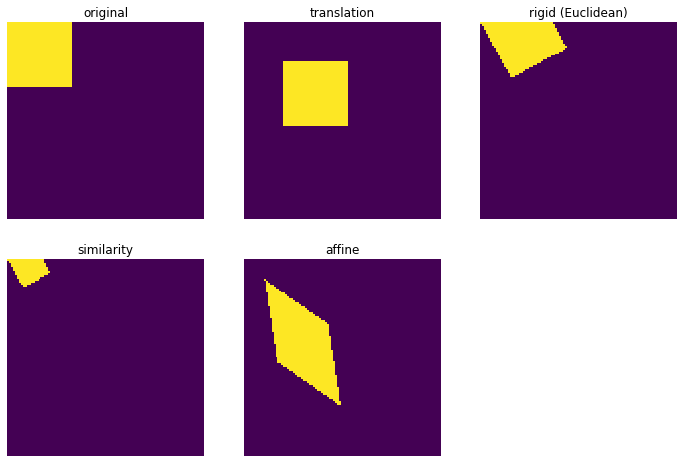

In [66]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
img = np.zeros((100, 100))

img[:33, :33] = 1
imshow(img, axs[0][0], title="original", bgr=False)

M_trans = np.array([[1, 0, 20], [0, 1., 20]])
img_trans = cv2.warpAffine(img, M_trans, (100, 100))
imshow(img_trans, axs[0][1], title="translation", bgr=False)

M_rotation = np.array([[np.cos(0.5), np.sin(0.5), 0], 
                       [-np.sin(0.5), np.cos(0.5), 0]])
img_rotation = cv2.warpAffine(img, M_rotation, (100, 100))
imshow(img_rotation, axs[0][2], title="rigid (Euclidean)", bgr=False)

M_sim = np.array([[np.cos(0.5), np.sin(0.5), 0], 
                       [-np.sin(0.5), np.cos(0.5), 0]]) * 0.5
img_sim = cv2.warpAffine(img, M_sim, (100, 100))
imshow(img_sim, axs[1][0], title="similarity", bgr=False)

M_aff = np.array([[1, 0.2, 10], 
                  [0.7, 1.3, 10]])
img_aff = cv2.warpAffine(img, M_aff, (100, 100))
imshow(img_aff, axs[1][1], title="affine", bgr=False)

axs[1][2].set_axis_off()

## Projective Transformations
$$w\begin{bmatrix}x'\\y'\\1\end{bmatrix} = 
\begin{bmatrix}a&b&e\\c&d&f\\g&h&i\end{bmatrix} \begin{bmatrix}x\\y\\1\end{bmatrix} $$
Note that this is an expansion of affine transformation, when $g=h=0$ and $i=1$
#### Properties
 - origin does not necessarily map to origin
 - Lines map to lines
 - __parallel are not necessarily remain parallel__
 - __Do not__ preserve ratios
 - closed under composition
 - rectangles goes to quadrilateral

### Solving Homographies
Let $(x_i,y_i)$ be a point on the reference (model) image, and $(x_i',y_i')$ be its matching in the test image, $H_{3\times 3}$ be the projective matrix. 
So that 
$$a\begin{bmatrix}x_i'\\y_i'\\1\end{bmatrix} = 
\begin{bmatrix}h_{00}&h_{01}&h_{02}\\
h_{10}&h_{11}&h_{12}\\h_{20}&h_{21}&h_{22}\end{bmatrix} \begin{bmatrix}x_i\\y_i\\1\end{bmatrix} $$
We need to solve the 9 unknowns $h_{[0:2, 0:2]}$ 
First, note that $$a = h_{20}x_i + h_{21}y_i + h_{22}$$
so that $$ax_i' = h_{00}x_i + h_{01}y_1 + h_{02}\Rightarrow x_i' = \frac{h_{00}x_i + h_{01}y_1 + h_{02}}{h_{20}x_i + h_{21}y_i + h_{22}} $$
$$y_i' = \frac{h_{10}x_i + h_{11}y_1 + h_{12}}{h_{20}x_i + h_{21}y_i + h_{22}}$$
rewrite them as linear equations
\begin{align*}
-(h_{20}x_i + h_{21}y_i + h_{22})x_i' + h_{00}x_i + h_{01}y_1 + h_{02} = 0\\
-(h_{20}x_i + h_{21}y_i + h_{22})y_i' + h_{10}x_i + h_{11}y_1 + h_{12} = 0
\end{align*}
i.e. 
$$\begin{bmatrix}
x_i &y_i&1&0&0&0&-x_i'x_i&-x_i'y_i &-x_i'\\
0 &0&0&x_i&y_i&1&-y_i'x_i&-y_i'y_i &-y_i'
\end{bmatrix}
h_F = \vec 0$$
where $h_F=[h_{00}, h_{01},...,h_{21},h_{22}]^T$ is the flatten vector of $H$

Since we have $n$ sets of matching points, we can have 
$$A_{2n\times 9} h_{F_9\times 1} = \vec 0_{2n}$$
and we want to find 
$$h = arg\min \|Ah\|_2^2$$

Since $h$ is only defined up to scale, we can first solve for unit vector and then multiply back scale. so that we can add constraint 
$\|h\|_2 = 1$ and 
$$h = arg\min_{\|h\|_2=1}\|Ah\|_2^2$$
For constrained optimization, we use method of Lagrange Multipliers
where $\hat h = $eigenvector of $A^TA$ with smallest eigenvalue. 

Notice that although we seem to have $9$ unknowns, we actually only have $8$, since the last one is calculated from the constraint. So that we only need $4$ matching to form a deterministic or over-deterministic system. 